# Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from encoders import FrequencyEncoder
from xgboost import XGBClassifier

# Custom Functions

In [11]:
# load data
def load_data():
    df = pd.read_csv('adult.csv')

    # Drop unused columns
    df = df.drop(['fnlwgt', 'educational-num'], axis = 1) 

    # Remove All Spaces from Strings in a DataFrame
    df = df.map(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

    # Replace "?" with NaN
    df.replace("?", np.nan, inplace=True)

    # Replace "Hong" with "HongKong"
    df['native-country'] = df['native-country'].replace("Hong", "Hong-Kong")

    # Drop Nan
    df = df.dropna()

    # Drp duplicate rows
    df = df.drop_duplicates()

    return df

# Plot histograms for all numerical features
def plot_numerical_histograms(df, numerical_features, bins=30, figsize=(15, 10), edgecolor='black', title='Histogram of All Numerical Features'):
    df[numerical_features].hist(bins=bins, figsize=figsize, edgecolor=edgecolor)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to fit suptitle
    plt.show()

# Plot Categorical Distributions using bar plot
def plot_categorical_distribution(df, columns, title=None, order=None, target=None):
    for col in columns:
        plt.figure(figsize=(8, 5))
        
        # Create the countplot
        ax = sns.countplot(x=col, data=df, hue=target, order=order)
        
        # Calculate percentages using pandas crosstab
        if target:
            # Get cross-tabulation
            ct = pd.crosstab(df[col], df[target], margins=False)
            # Calculate row percentages
            row_totals = ct.sum(axis=1)
        else:
            total = len(df)
            value_counts = df[col].value_counts()
        
        # Create a mapping of x-positions to categories
        tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
        
        # Add labels to bars
        for container_idx, container in enumerate(ax.containers):
            for bar_idx, bar in enumerate(container):
                count = int(bar.get_height())
                if count > 0:
                    # Add count label
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                           f'{count}', ha='center', va='center',
                           fontsize=8, color='white', fontweight='bold')
                    
                    # Calculate percentage
                    if target:
                        # Get category name from tick labels
                        if bar_idx < len(tick_labels):
                            cat_name_str = tick_labels[bar_idx]
                            # Try to find matching category in the dataframe
                            cat_name = cat_name_str
                            for unique_val in df[col].unique():
                                if str(unique_val) == cat_name_str:
                                    cat_name = unique_val
                                    break
                            
                            if cat_name in row_totals:
                                pct = (count / row_totals[cat_name]) * 100
                            else:
                                pct = 0
                        else:
                            pct = 0
                    else:
                        pct = (count / total) * 100
                    
                    # Add percentage label
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                           f'{pct:.1f}%', ha='center', va='bottom',
                           fontsize=8, fontweight='bold')
        
        # Formatting
        plt.xlabel(col.capitalize(), fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.title(title if title else f"Distribution of {col.capitalize()}", fontsize=14)
        plt.xticks(rotation=0)
        
        if target:
            plt.legend(title=target.capitalize(), fontsize=9, title_fontsize=10)
        
        plt.tight_layout()
        plt.show()

# Data Overview

In [3]:
df = pd.read_csv("adult.csv")

In [4]:
df.sample(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
21718,22,Private,153805,HS-grad,9,Never-married,Other-service,Unmarried,Other,Male,0,0,20,Puerto-Rico,<=50K
27776,54,Self-emp-not-inc,136224,Masters,14,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,30,United-States,<=50K
18681,46,Private,121124,Assoc-acdm,12,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,50,United-States,>50K
13910,73,Self-emp-inc,80986,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,20,United-States,<=50K
13528,48,Private,38950,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,50,United-States,>50K


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1   workclass        32561 non-null  object
 2   fnlwgt           32561 non-null  int64 
 3   education        32561 non-null  object
 4   educational-num  32561 non-null  int64 
 5   marital-status   32561 non-null  object
 6   occupation       32561 non-null  object
 7   relationship     32561 non-null  object
 8   race             32561 non-null  object
 9   gender           32561 non-null  object
 10  capital-gain     32561 non-null  int64 
 11  capital-loss     32561 non-null  int64 
 12  hours-per-week   32561 non-null  int64 
 13  native-country   32561 non-null  object
 14  income           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Cleaning for EDA

In [6]:
# drop unused columns
df = df.drop(['fnlwgt', 'educational-num'], axis = 1) 

# Remove All Spaces from Strings in a DataFrame
df = df.map(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

# Replace "?" with NaN
df.replace("?", np.nan, inplace=True)

# Replace "Hong" with "HongKong"
df['native-country'] = df['native-country'].replace("Hong", "Hong-Kong")

In [7]:
df.isnull().sum()

age                  0
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
gender               0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [8]:
# Drop missing values
df_clean = df.dropna()

In [9]:
df_clean.isnull().sum()

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [10]:
df_clean.duplicated().sum()

np.int64(3258)

In [11]:
# drop duplicates rows
df_clean = df_clean.drop_duplicates()

In [12]:
df_clean.duplicated().sum()

np.int64(0)

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26904 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26904 non-null  int64 
 1   workclass       26904 non-null  object
 2   education       26904 non-null  object
 3   marital-status  26904 non-null  object
 4   occupation      26904 non-null  object
 5   relationship    26904 non-null  object
 6   race            26904 non-null  object
 7   gender          26904 non-null  object
 8   capital-gain    26904 non-null  int64 
 9   capital-loss    26904 non-null  int64 
 10  hours-per-week  26904 non-null  int64 
 11  native-country  26904 non-null  object
 12  income          26904 non-null  object
dtypes: int64(4), object(9)
memory usage: 2.9+ MB


# Exploratory Data Analysis

In [14]:
# Classify columns by data types in df_clean
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
binary_cols = ['gender']
ordinal_cols = ['education']
nominal_cols = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'native-country'
]
print("Binary columns:", binary_cols)
print("Ordinal columns:", ordinal_cols)
print("Nominal columns:", nominal_cols)
print("Numeric columns:", numeric_cols)

Binary columns: ['gender']
Ordinal columns: ['education']
Nominal columns: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Numeric columns: ['age', 'capital-gain', 'capital-loss', 'hours-per-week']


## Target Overview

In [15]:
df_clean['income'].value_counts()

income
<=50K    20024
>50K      6880
Name: count, dtype: int64

## Numerical Features

### Statistical Summary

In [16]:
df_clean[numeric_cols].describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
age,26904.0,39.049,13.189,17.0,29.0,38.0,48.0,90.0
capital-gain,26904.0,1215.398,7805.225,0.0,0.0,0.0,0.0,99999.0
capital-loss,26904.0,98.506,425.679,0.0,0.0,0.0,0.0,4356.0
hours-per-week,26904.0,41.165,12.347,1.0,40.0,40.0,45.0,99.0


### Skewness

In [17]:
df_clean[numeric_cols].skew()

age                0.514825
capital-gain      11.277023
capital-loss       4.252867
hours-per-week     0.343396
dtype: float64

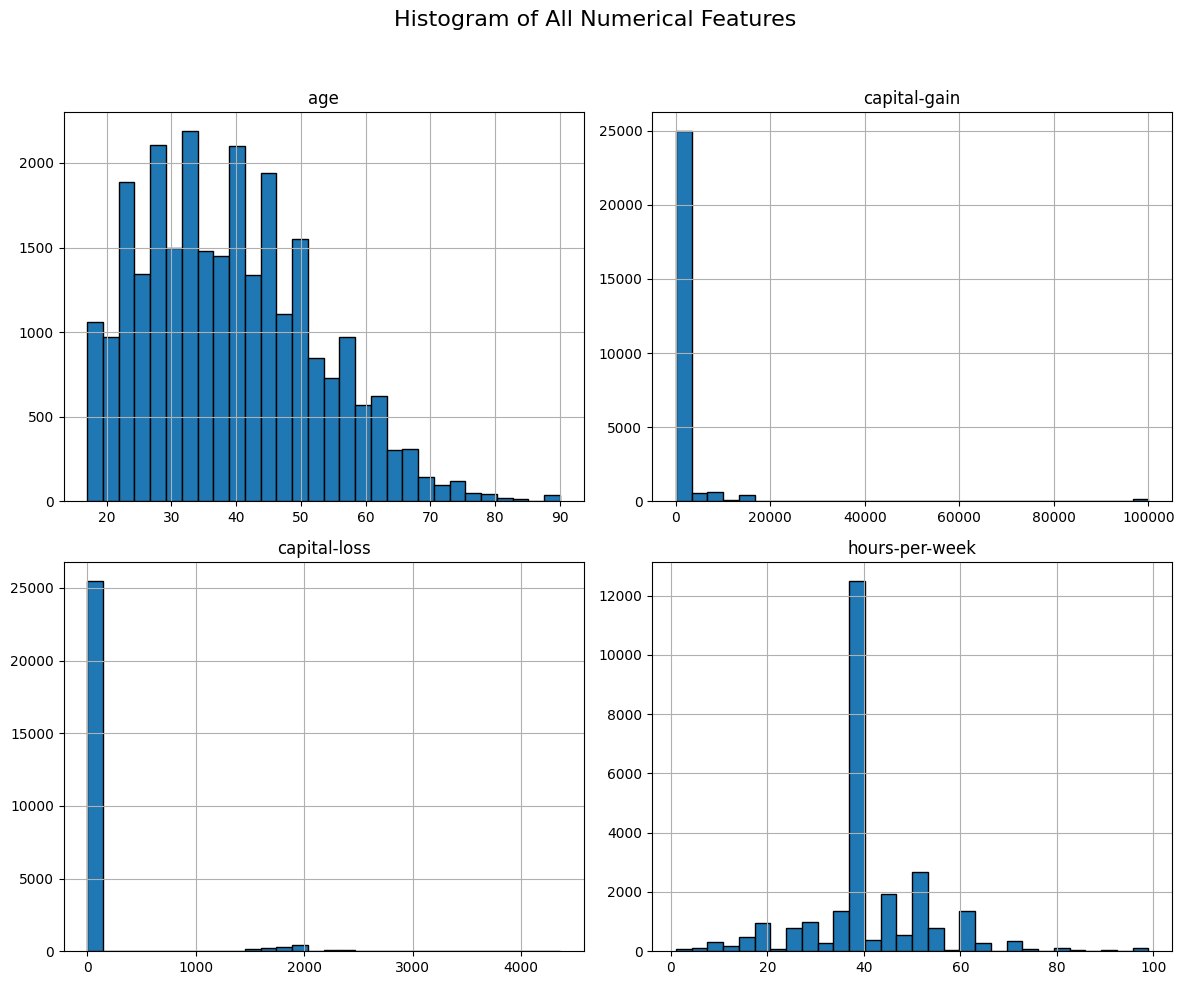

In [18]:
plot_numerical_histograms(df_clean, numeric_cols, bins=30, figsize=(12, 10), edgecolor='black', title='Histogram of All Numerical Features')

### Correlation Matrix

In [19]:
tmp_df = df_clean.copy()
tmp_df['income_bin'] = tmp_df['income'].map({'<=50K': 0, '>50K': 1})
corr_cols = numeric_cols + ['income_bin']

tmp_df[corr_cols].corr()

,age,capital-gain,capital-loss,hours-per-week,income_bin
age,1.000000,0.077238,0.052562,0.072530,0.223511
capital-gain,0.077238,1.000000,-0.036035,0.079403,0.228867
capital-loss,0.052562,-0.036035,1.000000,0.049053,0.153109
hours-per-week,0.072530,0.079403,0.049053,1.000000,0.225813
income_bin,0.223511,0.228867,0.153109,0.225813,1.000000


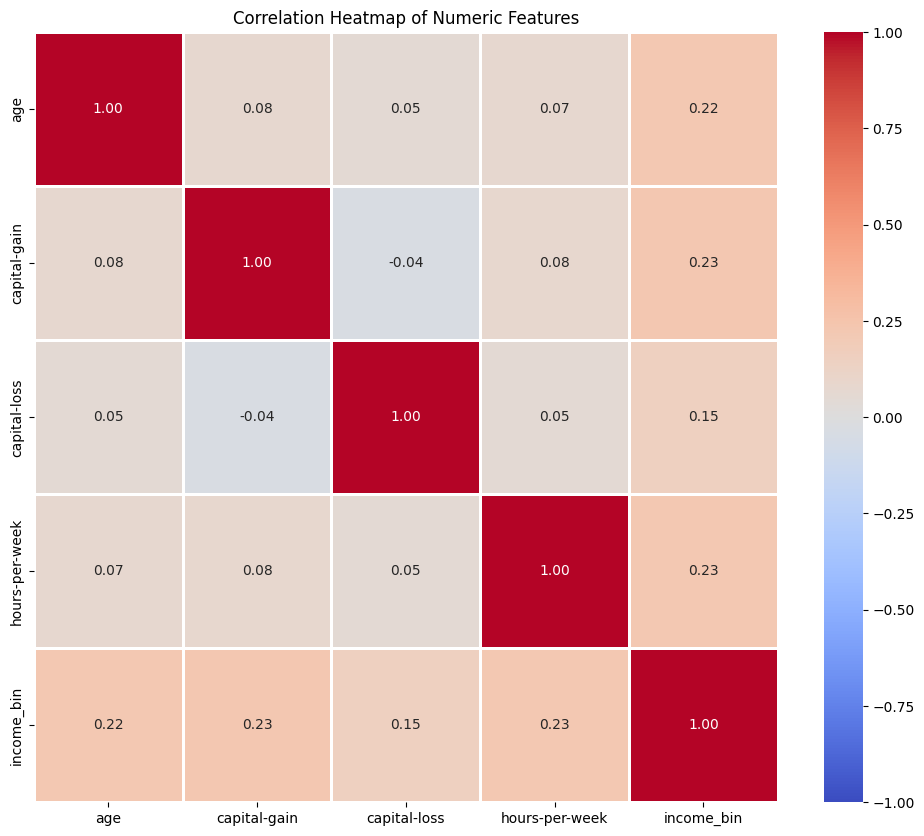

In [20]:
# Heatmap to find any high correlations
plt.figure(figsize=(12,10))
sns.heatmap(tmp_df[corr_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

## Categorical Features

### Binary

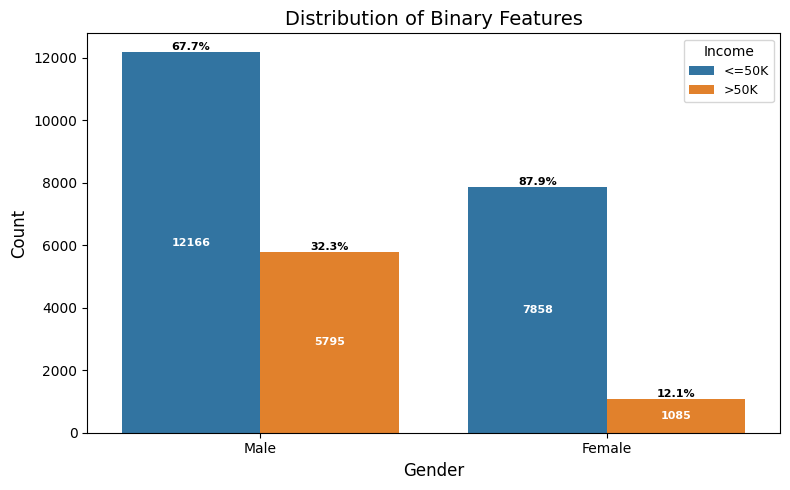

In [21]:
plot_categorical_distribution(df_clean, binary_cols, title='Distribution of Binary Features', target='income')

### Nominal

In [22]:
df_clean[nominal_cols].nunique()

workclass          7
marital-status     7
occupation        14
relationship       6
race               5
native-country    41
dtype: int64

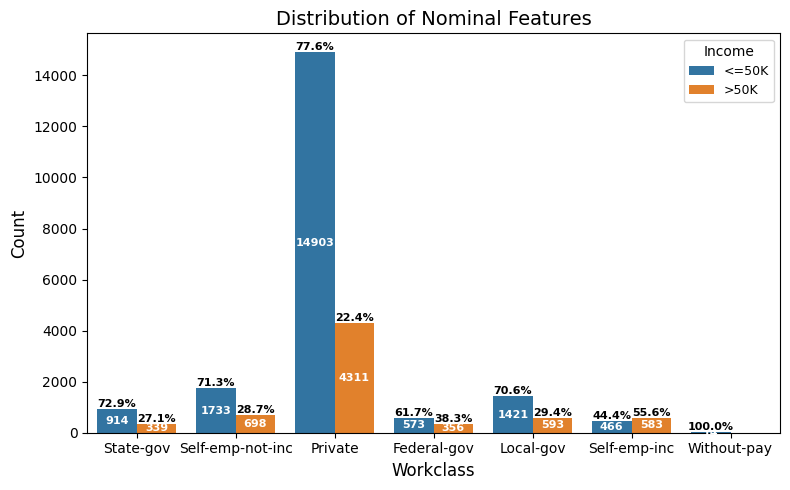

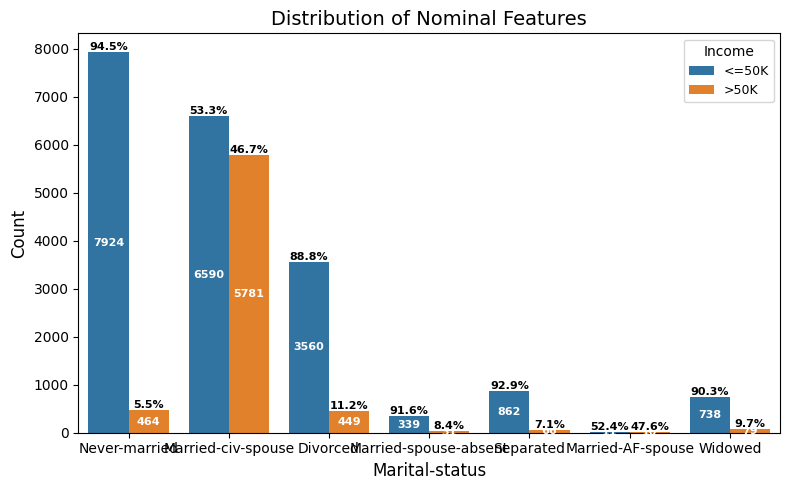

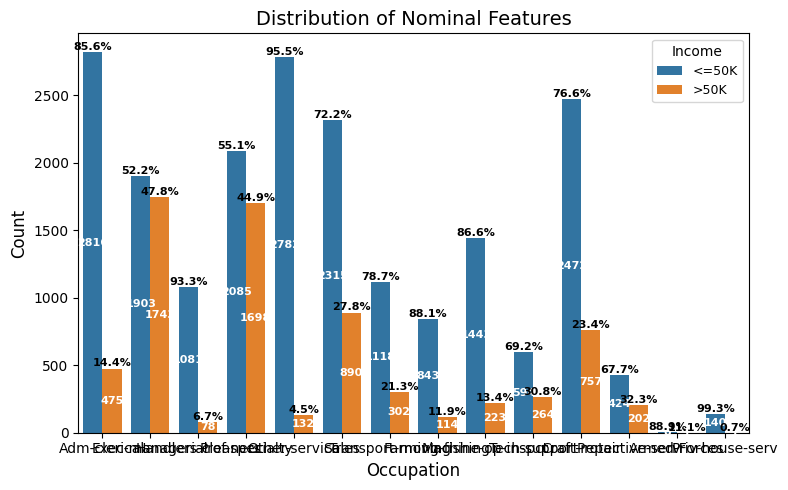

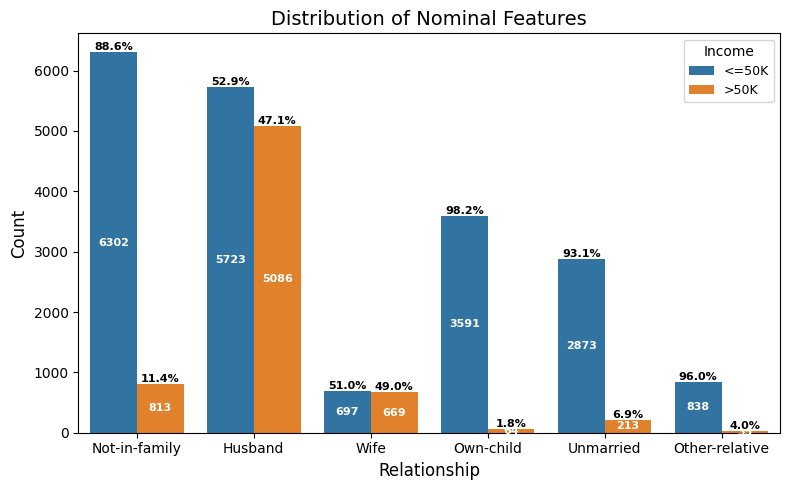

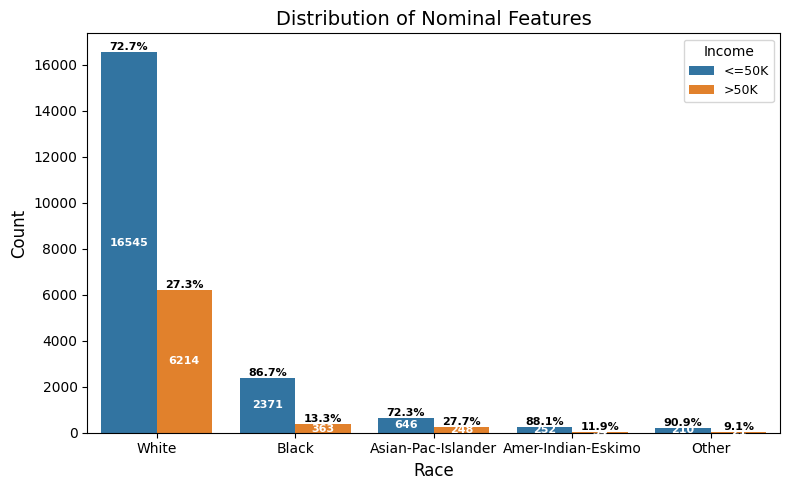

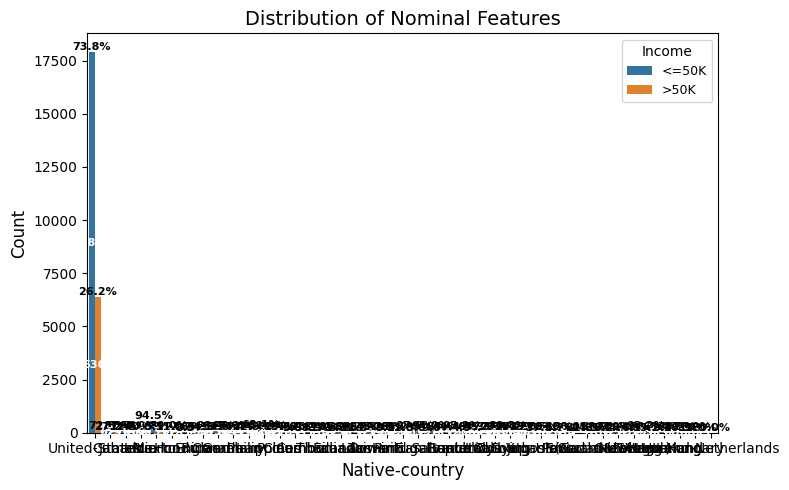

In [23]:
plot_categorical_distribution(df_clean, nominal_cols, title='Distribution of Nominal Features', target='income')

### Ordinal

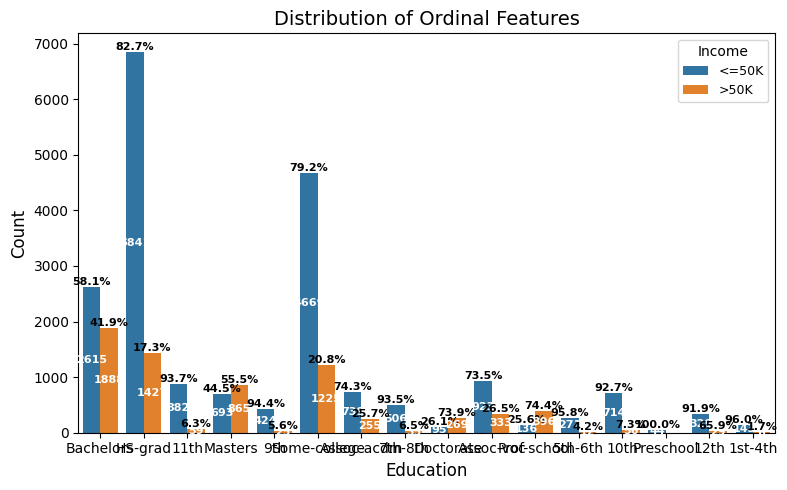

In [24]:
plot_categorical_distribution(df_clean, ordinal_cols, title='Distribution of Ordinal Features', target='income')

# Modeling

In [25]:
# Load the dataset
df = load_data()

# Separate features and target
X = df.drop("income", axis=1)
y = df["income"].apply(lambda x: 1 if x == ">50K" else 0)  # encode binary label

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Define transformers
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Updated ordinal transformer with error handling
ordinal_transformer = Pipeline(steps=[
    ("ordinal", OrdinalEncoder(
        categories=[['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
                    '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc',
                    'Assoc-acdm', 'Bachelors', 'Masters', 'Doctorate']],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

binary_transformer = Pipeline(steps=[
    ("binary_enc", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ("freq_enc", FrequencyEncoder())
])

# Combine into a ColumnTransformer
transformers = []

if numeric_cols:
    transformers.append(("num", numeric_transformer, numeric_cols))
if ordinal_cols:
    transformers.append(("ord", ordinal_transformer, ordinal_cols))
if binary_cols:
    transformers.append(("bin", binary_transformer, binary_cols))
if nominal_cols:
    transformers.append(("nom", nominal_transformer, nominal_cols))

preprocessor = ColumnTransformer(transformers=transformers)

# Calculate class weights properly
class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Create XGBoost model with updated parameters
model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=class_ratio,  # Handle class imbalance
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

# Build the full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Evaluate with Repeated Stratified K-Fold CV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)  # Reduced for faster execution

f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
print(f"Mean F1-score (CV): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
print(f"Individual F1 scores: {f1_scores}")

Mean F1-score (CV): 0.7252 ± 0.0054
Individual F1 scores: [0.72109882 0.7248062  0.72451686 0.73187572 0.72657154 0.73351125
 0.72593168 0.72959381 0.71582181 0.71814093]



Test F1-score: 0.7239


d:\azizp128-github\data-science-projects\income-prediction\venv\lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
d:\azizp128-github\data-science-projects\income-prediction\venv\lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


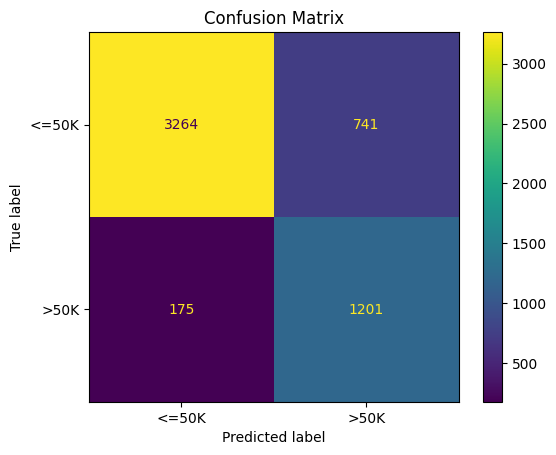

In [26]:
# Fit on full training data
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
test_f1 = f1_score(y_test, y_pred)
print(f"\nTest F1-score: {test_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["<=50K", ">50K"]))


Classification Report:
              precision    recall  f1-score   support

       <=50K       0.95      0.81      0.88      4005
        >50K       0.62      0.87      0.72      1376

    accuracy                           0.83      5381
   macro avg       0.78      0.84      0.80      5381
weighted avg       0.86      0.83      0.84      5381




Top 10 Feature Importances:
              feature  importance
7  nom_marital-status    0.521744
1    num_capital-gain    0.120992
8      nom_occupation    0.074809
4       ord_education    0.068718
2    num_capital-loss    0.047045
0             num_age    0.034629
3  num_hours-per-week    0.030798
5          bin_gender    0.030001
9    nom_relationship    0.021462
6       nom_workclass    0.019260


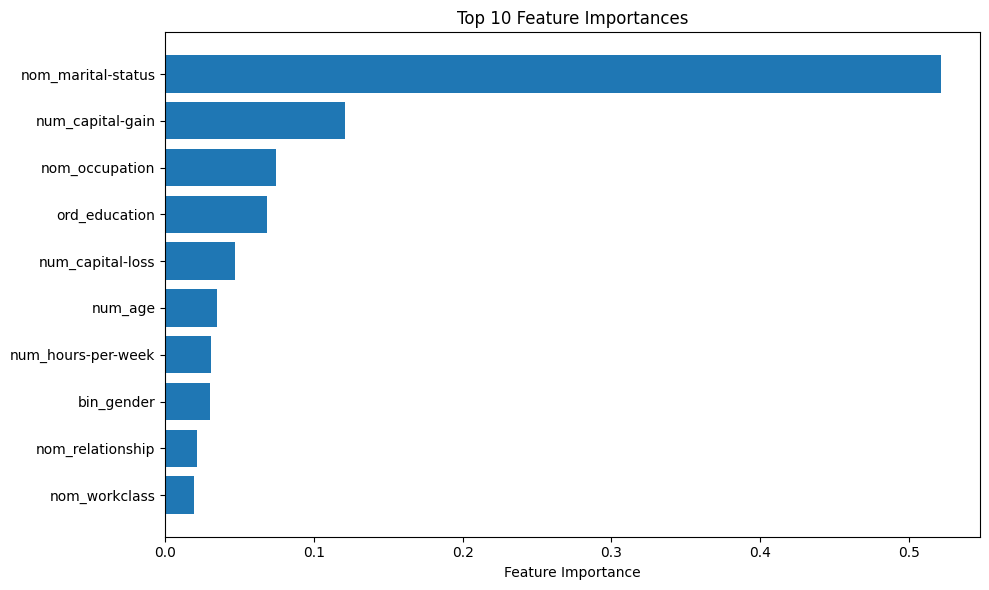

In [28]:
# 12. Feature importance
try:
    feature_names = (numeric_cols + ordinal_cols + binary_cols + 
                    [f"nom_{i}" for i in range(len(nominal_cols))])
    
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = pipeline.named_steps['classifier'].feature_importances_
        
        # Get feature names from preprocessor
        feature_names = []
        if numeric_cols:
            feature_names.extend([f"num_{col}" for col in numeric_cols])
        if ordinal_cols:
            feature_names.extend([f"ord_{col}" for col in ordinal_cols])
        if binary_cols:
            feature_names.extend([f"bin_{col}" for col in binary_cols])
        if nominal_cols:
            feature_names.extend([f"nom_{col}" for col in nominal_cols])
        
        # Ensure we have the right number of feature names
        if len(feature_names) == len(importances):
            feature_importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            print("\nTop 10 Feature Importances:")
            print(feature_importance_df.head(10))
            
            # Plot feature importance
            plt.figure(figsize=(10, 6))
            top_features = feature_importance_df.head(10)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 10 Feature Importances')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            
except Exception as e:
    print(f"Could not extract feature importance: {e}")

# Save Model

In [12]:
# Load the dataset
df = load_data()

# Classify columns by data types in df
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
binary_cols = ['gender']
ordinal_cols = ['education']
nominal_cols = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'native-country'
]

# Separate features and target
X = df.drop("income", axis=1)
y = df["income"].apply(lambda x: 1 if x == ">50K" else 0)  # encode binary label

# Define transformers
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Updated ordinal transformer with error handling
ordinal_transformer = Pipeline(steps=[
    ("ordinal", OrdinalEncoder(
        categories=[['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
                    '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc',
                    'Assoc-acdm', 'Bachelors', 'Masters', 'Doctorate']],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

binary_transformer = Pipeline(steps=[
    ("binary_enc", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ("freq_enc", FrequencyEncoder())
])

# Combine into a ColumnTransformer
transformers = []

if numeric_cols:
    transformers.append(("num", numeric_transformer, numeric_cols))
if ordinal_cols:
    transformers.append(("ord", ordinal_transformer, ordinal_cols))
if binary_cols:
    transformers.append(("bin", binary_transformer, binary_cols))
if nominal_cols:
    transformers.append(("nom", nominal_transformer, nominal_cols))

preprocessor = ColumnTransformer(transformers=transformers)

# Calculate class weights properly
class_ratio = len(y[y == 0]) / len(y[y == 1])

# Create XGBoost model with updated parameters
model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=class_ratio,  # Handle class imbalance
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

# Build the full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Fit the pipeline on the full dataset
pipeline.fit(X, y)

# Save the pipeline
joblib.dump(pipeline, "pipeline.joblib")

['pipeline.joblib']